In [1]:
%matplotlib inline
import sys, importlib, os
import McsPy.McsData
import McsPy.McsCMOS
from McsPy import ureg, Q_

# matplotlib.pyplot will be used in these examples to generate the plots visualizing the data
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.widgets import Slider
import numpy as np
from scipy import signal

# import datashader as ds
# import datashader.transfer_functions as tf
import pandas as pd
import numpy as np
import pynapple as nap


import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

na = np.array
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

In [2]:
import h5py

In [3]:
%%time
file_names = ['/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/Shaima_example/2025-01-17T21-17-46McsRecording.h5',
              ]
rec_length = []
name = ['WT1']
# for n_file,file_name in enumerate(file_names):
file_name = '/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/Shaima_example/2025-01-17T21-17-46McsRecording.h5'


with h5py.File(file_name, "r") as f:
    data= f['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData']
    print(data)
    # chunk_size = 1000  # Choose an optimal chunk size
    # for i in range(0, dataset.shape[0], chunk_size):
    # for i in range(252):
    data_chunk = data[:,:119554]  # Process in chunks


channel_raw_data = McsPy.McsData.RawData(file_name)    

adc_step = analog_stream_0.channel_infos[2].adc_step.magnitude 
# # get channel IDs
# channel_ids =list(channel_raw_data.recordings[0].analog_streams[0].channel_infos)
# channel_ids = np.hstack(channel_ids)
# channel_labels = [channel_raw_data.recordings[0].analog_streams[0].channel_infos[i].info['Label'] for i in channel_ids]
# analog_stream_0_data = analog_stream_0.channel_data
# #get offsets
# offsets = [analog_stream_0.channel_infos[id_].get_field('ADZero') for id_ in channel_ids]
# y =  data_chunk#na(analog_stream_0_data)#signal.copy() #= channel_raw_data.recordings[0].analog_streams[0].get_channel_in_range(1,252,0,2)#na(analog_stream_0_data)
# # correct to Volts
# y = np.subtract(y,na(offsets).reshape(-1,1))*adc_step
# x =np.arange(0,len(y[0,:]))/fs

NameError: name 'h5py' is not defined

In [5]:
channel_raw_data = McsPy.McsData.RawData(file_name)    

adc_step = analog_stream_0.channel_infos[2].adc_step.magnitude 

NameError: name 'analog_stream_0' is not defined

In [3]:
file_name = '/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/Shaima_example/2025-01-17T21-17-46McsRecording.h5'
channel_raw_data = McsPy.McsData.RawData(file_name)    
analog_stream_0 = channel_raw_data.recordings[0].analog_streams[0]
adc_step = analog_stream_0.channel_infos[2].adc_step.magnitude 

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (252, 11955468), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (252,), type "|V108">


In [7]:
adc_step

3.0710999999999996e-08

In [44]:
chunnks = get_all_chunk_bounds(11955468,100000)

In [45]:
(len(chunnks))

120

In [46]:

with h5py.File(file_name, "r") as f:
    data= f['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData']
    print(data)
    # chunk_size = 1000  # Choose an optimal chunk size
    for k in chunnks[:]:
        data_chunk = data[:,k[0]:k[1]]  # Process in chunks


<HDF5 dataset "ChannelData": shape (252, 11955468), type "<i4">


In [11]:
11955468//10

1195546

In [37]:
11955468/5

2391093.6

In [48]:
import numpy as np
from scipy.signal import butter, lfilter, lfilter_zi
# from scipy.signal import butter, sosfilt, sosfilt_zi
from scipy.signal import butter, sosfiltfilt

def get_all_chunk_bounds(total_length, chunk_size):
    chunks = []
    for i in range(0, total_length, chunk_size):
        start = i
        end = min(i + chunk_size, total_length)
        chunks.append((start, end))
    return chunks
# Design filter (Butterworth bandpass)
def design_filter(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    b = butter(order, highcut / nyq, btype='low', output='sos')#butter(order, [lowcut / nyq, highcut / nyq], btype='band', output='sos')
    return b
file_name = '/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/Shaima_example/2025-01-17T21-17-46McsRecording.h5'

# Apply filter chunk-by-chunk\
fs = 10000
n_channels=252
b = design_filter(.1, 200, fs)
length = []
# with open('/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/Shaima_example/filt.bin', 'wb') as f_out:
with h5py.File('/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/Shaima_example/filt.h5', 'w') as write_file:

    dset = write_file.create_dataset(
        'data',
        shape=(0, 252),             # start with 0 rows
        maxshape=(None, 252),       # allow unlimited rows
        chunks=(100000, 252),   # efficient I/O chunks
        dtype='float32',
        compression='lzf'                 # optional: for smaller files
    )

with h5py.File('/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/Shaima_example/filt.h5', 'a') as write_file:
    dset = write_file['data']
    # Read chunk (adapt depending on file format)
    with h5py.File(file_name, "r") as f:

        data= f['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData']
        chunnks = get_all_chunk_bounds(data.shape[1],100000)        # chunk_size = 1000  # Choose an optimal chunk size
        for k in chunnks[:]:
            data_chunk = data[:,k[0]:k[1]]  # Process in chunks
            filtered_chunk = sosfiltfilt(b, data_chunk[:,:].T,axis=0)
            filtered_chunk = filtered_chunk[::20,:]
            current_rows = dset.shape[0]
            new_rows = current_rows + filtered_chunk.shape[0]
            dset.resize((new_rows, n_channels))
            dset[current_rows:new_rows, :] = filtered_chunk.astype(np.float32)
    write_file.attrs['resamped_rate'] = 500
    write_file.attrs['filter'] = 'lowpass 200Hz, order=5, zero-phase'
    write_file.attrs['scale'] = adc_step

            # filtered_chunk.astype(np.float16).tofile(f_out)
            # f.create_dataset(
            #         'data',
            #         data=filtered_chunk.astype(np.float32),
            #         compression='gzip',   # or 'lzf' for faster compression
            #         compression_opts=4    # 0–9 for gzip; higher = smaller but slower
            #     )
            # length.append(filtered_chunk.astype(np.float16).shape)

# plt.plot(filtered_chunk)

NameError: name 'write_filef' is not defined

In [14]:
filtered_chunk.shape

(2774, 252)

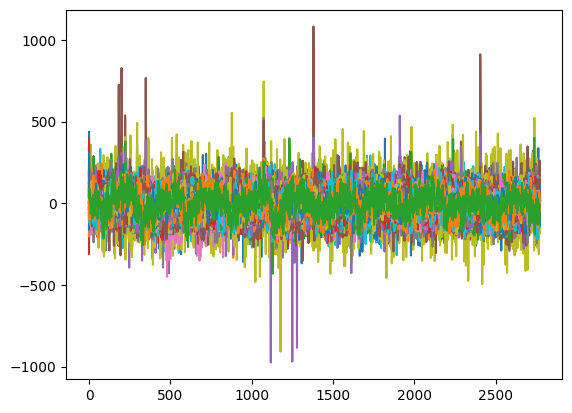

In [13]:
plt.figure()
plt.plot(data_chunk[10,::20])
plt.plot(filtered_chunk[:])
plt.show()

In [18]:
plt.plot(filtered_chunk)
data_chunk



In [16]:
with open('/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/Shaima_example/filt.bin', 'rb') as f_out:
    filt = np.fromfile(f_out)
    filt = filt.reshape(filt.shape[0]//252,252)
    # print(filt.shape)

ValueError: cannot reshape array of size 37659762 into shape (149443,252)

In [49]:
# with h5py.File('filtered.h5', 'r') as f:
with h5py.File('/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/Shaima_example/filt.h5', 'r') as f:
    filt = f['data'][:]

In [30]:
filt.shape

(597774, 252)

In [19]:
na(length).sum(0)

array([597774,  30240])

In [22]:
597774* 252

150639048

In [45]:
file_name = '/Users/ovinogradov/Documents/Projects/SCN1A/MEA-analysis/data/Shaima_example/2025-01-17T21-17-46McsRecording.h5'

with h5py.File(file_name, "r") as f:
    data= f['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData']
    print(data)
    # chunk_size = 1000  # Choose an optimal chunk size
    data_series = data[10,:]  # Process in chunks

<HDF5 dataset "ChannelData": shape (252, 11955468), type "<i4">


In [44]:
data_series.shape

(252,)

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


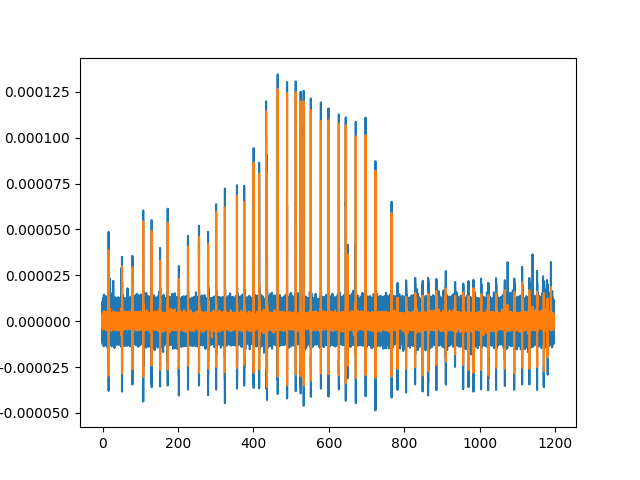

In [50]:

%matplotlib widget
plt.figure()
plt.plot(np.arange(0,len(data_series))*(1/10000),data_series*adc_step)
plt.plot(np.arange(0,len(filt))*(1/500),filt[:,10]*adc_step,'-')

# plt.show()

/Users/ovinogradov/miniconda3/envs/sliceMEA/lib/python3.9/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


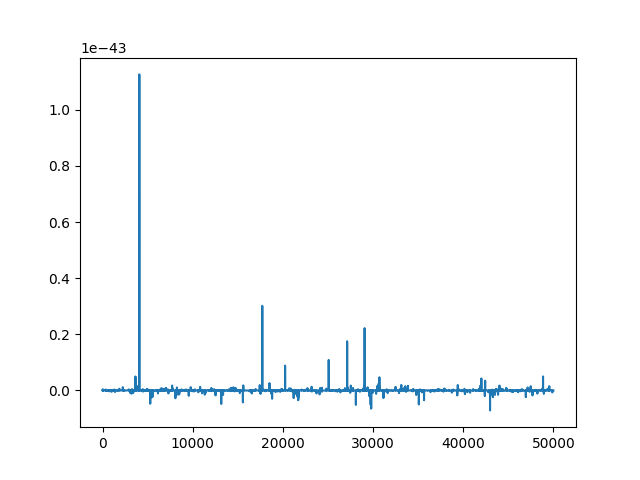

In [105]:
plt.figure()
plt.plot(filt[:])
plt.show()
